In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import modeling
print(modeling.__version__)

0.0.1.dev0


In [11]:
import numpy as np
import matplotlib.pyplot as pl

from modeling import ModelMixin, Parameter, Relationship, parameter_sort

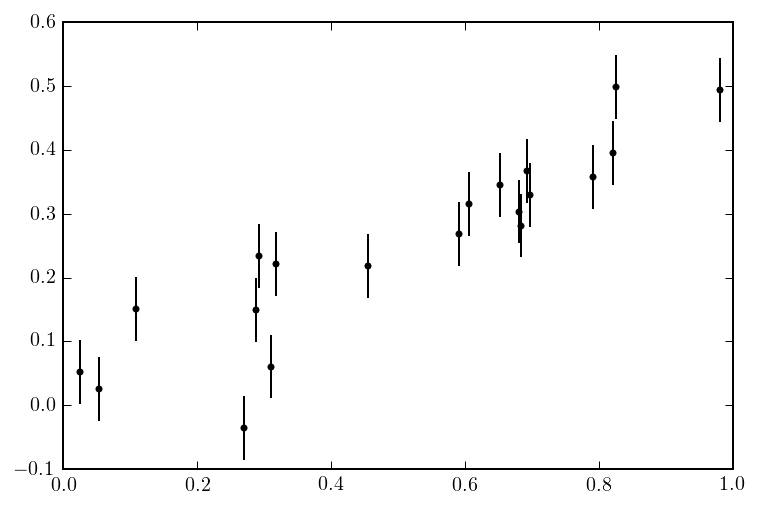

In [4]:
x = np.random.rand(20)
yerr = 0.05 + np.zeros_like(x)
y = 0.5 * x + 0.05 + np.sqrt(yerr**2 + 0.05**2) * np.random.randn(len(x))

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0);

In [36]:
class LinearModel(ModelMixin):
    
    m = Parameter()
    b = Parameter()

    def get_value(self, x):
        return self.m * x + self.b
    
    @parameter_sort
    def get_value_and_gradient(self, x):
        return self.get_value(x), dict(m=x, b=np.ones_like(x))


class JitterModel(ModelMixin):
    
    mean = Relationship(LinearModel)
    log_sigma = Parameter()
    
    sigma = Parameter(depends=log_sigma)
    
    @sigma.getter
    def get_sigma(self):
        return np.exp(self.log_sigma)
    
    @sigma.setter
    def set_sigma(self, value):
        self.log_sigma = np.log(value)
        
    def __init__(self, x, y, yerr, **kwargs):
        self.x = x
        self.y = y
        self.yvar = yerr ** 2
        
        super(JitterModel, self).__init__(**kwargs)
        
    def get_value(self):
        var = self.yvar + self.sigma**2
        delta = self.y - self.mean.get_value(self.x)
        return -0.5 * np.sum(delta**2 / var + np.log(var))
    
    @parameter_sort
    def get_value_and_gradient(self):
        model, model_grad = self.mean.get_value_and_gradient(self.x)
        var = self.yvar + self.sigma**2
        delta = self.y - model
        value = -0.5 * np.sum(delta**2 / var + np.log(var))
        
        grad = dict(log_sigma=self.sigma**2*np.sum(delta**2/var**2 - 1.0 / var))
        for i, k in enumerate(self.mean.get_parameter_names()):
            grad["mean:" + k] = np.dot(model_grad[i], delta / var)
        
        return value, grad

In [37]:
model = JitterModel(x, y, yerr, mean=LinearModel(m=0.2, b=0.0), log_sigma=0.1)

In [38]:
model.get_parameter_names()

['log_sigma', 'mean:m', 'mean:b']

In [39]:
model.get_vector()

array([ 0.1,  0.2,  0. ])

In [40]:
model.test_gradient()

True

In [41]:
from scipy.optimize import minimize

In [42]:
def nll(p):
    model.set_vector(p)
    v, g = model.get_value_and_gradient()
    return -v, -g

r = minimize(nll, model.get_vector(), jac=True)

In [43]:
r

 hess_inv: array([[  2.10103096e-01,  -3.18820990e-06,   7.54830631e-06],
       [ -3.18820990e-06,   2.54545018e-03,  -1.28789175e-03],
       [  7.54830631e-06,  -1.28789175e-03,   8.43535163e-04]])
     nfev: 29
   status: 0
      nit: 14
      fun: -45.68860379578346
        x: array([-3.31702569,  0.48009229,  0.00817683])
      jac: array([  3.21378575e-08,  -3.64773450e-07,  -8.33182881e-07])
  success: True
     njev: 29
  message: 'Optimization terminated successfully.'

In [45]:
model.get_vector()

array([-3.31702569,  0.48009229,  0.00817683])